# 3D Tomography Experiments

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### medium

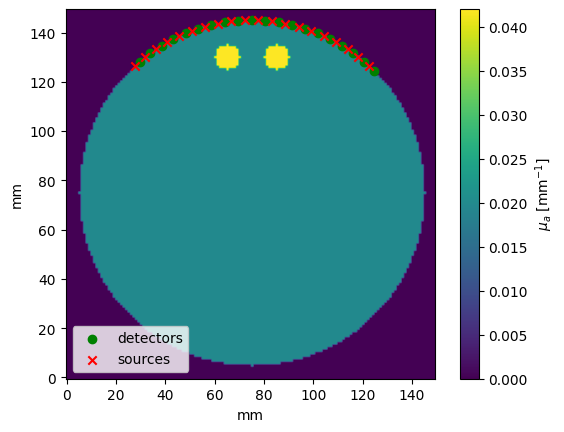

In [4]:
from problems.two_balls import two_balls_2d_sensors, two_balls_2d_medium

medium_bg, medium_true = two_balls_2d_medium(
    contrast=1.1, voxels_per_dim=150, r_ball_mm=5, depth_mm=20, ball_separation_mm=10
)

noptodes = 20
sensors = two_balls_2d_sensors(noptodes, medium_bg)

medium_true.plot_mua(sensors)

## Forward

In [28]:
from solver import Solver, jacobian

solver = Solver(medium_bg, sensors, tstart=0, tend=1e-8, tstep=1e-8)

In [29]:
nx, ny, nz = medium_bg.nx, medium_bg.ny, medium_bg.nz
ndet, nsrc = sensors.ndet, sensors.nsrc
nt = solver.nt

In [30]:
# initialize arrays
J = np.zeros((nz, ny, nx, nt, ndet, nsrc))
data_bg = np.zeros((nt, ndet, nsrc))
data_true = np.zeros((nt, ndet, nsrc))
t = np.linspace(solver.tstart, solver.tend, nt)

# run forward for all sources (for both the ground truth and background)
for src_idx in range(nsrc):
# src_idx = 1
    print(f"Running source {src_idx+1}/{nsrc}")
    solver.medium = medium_bg
    res_bg, cfg_bg = solver.forward(src_idx, random_seed=2)

    data_bg[..., src_idx] = solver.get_td_data(res_bg, medium_bg.optical_properties)
    J[..., src_idx] = jacobian(res_bg, cfg_bg)

    solver.medium = medium_true
    res_true, cfg_true = solver.forward(src_idx, random_seed=7)
    data_true[..., src_idx] = solver.get_td_data(res_true, medium_true.optical_properties) # note we use the same photons as the forward pass

Running source 1/20
nphoton: 1e+08
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1e+08
issrcfrom0: 1
replaydet: -1
srcpos: [0, 126.403, 122.516, 1]
srcdir: [0, -0.734322, -0.678801, 0]
issavedet: 1


issaveseed: 1
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse,#
#  Please consider using J

## Number of photons test
Are we shooting enough photons?

In [33]:
nruns = 10
nphoton = 1e5

data_bg = np.zeros((nruns, nt, ndet))

# run forward for all sources (for both the ground truth and background)
src_idx = 1
for i in range(nruns):
    solver.medium = medium_bg
    res_bg, cfg_bg = solver.forward(src_idx, random_seed=i, nphoton=nphoton)
    data_bg[i, ...] = solver.get_td_data(res_bg, medium_bg.optical_properties)

solver.medium = medium_true
res_true, cfg_true = solver.forward(src_idx, random_seed=7, nphoton=nphoton)
data_true = solver.get_td_data(res_true, medium_true.optical_properties) # note we use the same photons as the forward pass

nphoton: 100000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 100000
issrcfrom0: 1
replaydet: -1
srcpos: [0, 129.972, 118.337, 1]
srcdir: [0, -0.785317, -0.619094, 0]
issavedet: 1
issaveseed: 1
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  

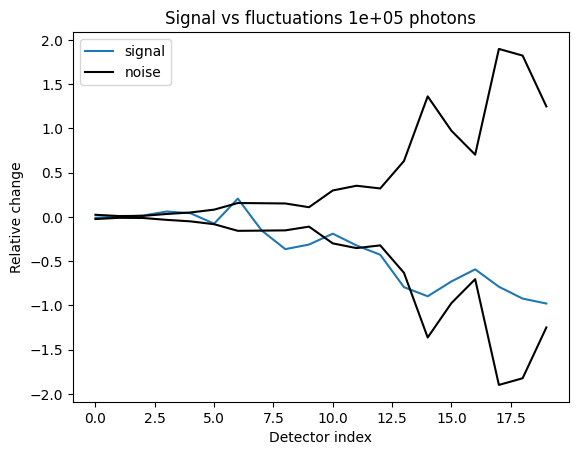

In [43]:
data_bg_mean = data_bg.mean(axis=0)
data_bg_std = data_bg.std(axis=0)

plt.xlabel("Detector index")
plt.ylabel("Relative change")
relative_change = (data_true - data_bg_mean) / data_bg_mean
noise = data_bg_std[0]/ data_bg_mean[0]
plt.plot(relative_change[0], label="signal")
plt.plot(noise, label="noise", color="black")
plt.plot(-noise, color="black")
plt.legend()
plt.title(f"Signal vs fluctuations {nphoton:.0e} photons")
plt.show()

## Inversion

In [31]:
# get the condition number of J
J_c = J.reshape((nz*ny*nx*nt, ndet*nsrc))
cond = np.linalg.cond(J_c)
print(f"Condition number of J: {cond}")

Condition number of J: 9928.57668589853


In [32]:
from solver import invert, compute_dphi
# normalize true data
dphi_fd = compute_dphi(data_bg, data_true)

mua_bg = medium_bg.get_mua()
dmua = invert(dphi_fd, J)

mua_new = mua_bg + dmua

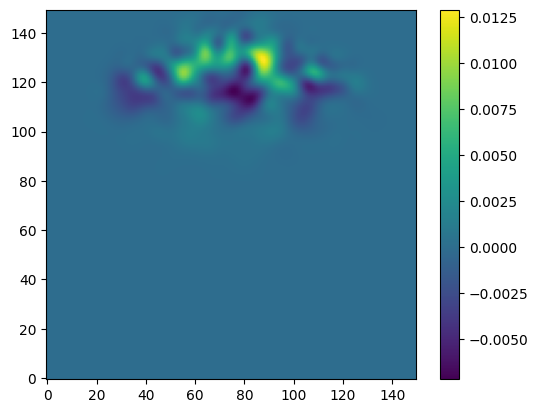

In [27]:
# blur the result
from scipy.ndimage import gaussian_filter
dmua2 = gaussian_filter(dmua, sigma=3)


plt.imshow(dmua2[nz//2,...])
plt.colorbar()
# flip y axis
plt.gca().invert_yaxis()